In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt

In [2]:
data_uniform=np.load(r"C:\Users\stone\Desktop\Synthetic_data_no_defect\2025_10_24_sample_100x100x5mm_no_defect_isotropic.npz",allow_pickle=True)
data_gauss=np.load(r"C:\Users\stone\Desktop\Synthetic_data_no_defect\2025_10_24_sample_100x100x5mm_no_defect_isotropic_gaussian_heat.npz",allow_pickle=True)
data_gauss_5=np.load(r"C:\Users\stone\Desktop\Synthetic_data_no_defect\2025_10_24_sample_100x100x5mm_no_defect_isotropic_gaussian_heat.npz",allow_pickle=True)

In [4]:
ccase=torch.from_numpy(data_uniform['data']).to(torch.float32)

In [5]:
ccase.size()

torch.Size([3304, 512, 512])

In [13]:
def sobol_integer_grid(n_points, size=512):
    sobol = torch.quasirandom.SobolEngine(dimension=2, scramble=True)
    
    # Draw extra points because duplicates will appear after rounding
    pts = sobol.draw(n_points * 2)

    # Scale to pixel grid and convert to integers
    pts = (pts * (size - 1)).round().long()

    # Remove duplicates
    pts = torch.unique(pts, dim=0)

    # If still not enough, repeat until filled
    while pts.size(0) < n_points:
        extra = sobol.draw(n_points).mul(size - 1).round().long()
        pts = torch.unique(torch.cat([pts, extra], dim=0), dim=0)

    # Return only required number
    pts = pts[:n_points]

    X = pts[:, 0]
    Y = pts[:, 1]
    return X, Y

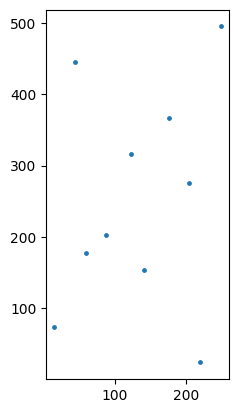

In [ ]:
X, Y = sobol_integer_grid(10, size=512)

plt.scatter(X, Y, s=6)
plt.gca().set_aspect('equal')
plt.show()

In [ ]:
class data_generator:
    def __init__(self,data):
        self.data=data

    
    def get_indexes(self,n_points):
        """
        Get psedo-random low discrepency indexes for sampling the data boundary conditions 
        
        """
        size=self.data.size(2)
        sobol = torch.quasirandom.SobolEngine(dimension=2, scramble=True)
        # Draw extra points because duplicates will appear after rounding
        pts = sobol.draw(n_points * 2)

        # Scale to pixel grid and convert to integers
        pts = (pts * (size - 1)).round().long()

        # Remove duplicates
        pts = torch.unique(pts, dim=0)

        # If still not enough, repeat until filled
        while pts.size(0) < n_points:
            extra = sobol.draw(n_points).mul(size - 1).round().long()
            pts = torch.unique(torch.cat([pts, extra], dim=0), dim=0)

        # Return only required number
        pts = pts[:n_points]

        X = pts[:, 0]
        Y = pts[:, 1]
        return X, Y

